**Business Objective**: In this capstone project, a customer ecommerce shopping transaction data from [Kaggle](https://www.kaggle.com/code/danofer/ecommerce-store-predict-purchases-data-prep/data?select=2019-Nov.csv) is used to evaluate data and compare the performance of recommendations models that are built based on Ensemble Modeling concept. The business objective of this project is to identify the feature (like brand, product etc) that influences the user to accept or reject coupons. 

This notebook containst the Exploratory Data Analysis (EDA) and plots for visual analysis of the data.

#### Libraries used in this application

In [ ]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import squarify
import os
import random

from matplotlib import rcParams
from scipy.linalg import svd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

import warnings
warnings.filterwarnings('ignore')

#### Data Understanding

In [ ]:
shopping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/shopping.csv')

The data for this project can be downloaded for this [kaggle](https://www.kaggle.com/code/danofer/ecommerce-store-predict-purchases-data-prep/data?select=2019-Nov.csv). This file contains behavior data for a one month (November 2019) from a large multi-category online store. 

Each row in the file represents an user event. All events are related to products and users. There are different types of events.

- event_time: Time when event happened at (in UTC).

- event_type : can be:
view - a user viewed a product
cart - a user added a product to shopping cart
purchase - a user purchased a product
Typical funnel: view => cart => purchase

- product_id: ID of a product

- category_id: Product's category ID

- category_code: multi-hierarchical name of Product's category

- brand: Downcased string of brand name

- price: Float price of a product. Present

- user_id: Permanent user ID

- user_session: Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.

In [ ]:
shopping.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [ ]:
shopping.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [ ]:
shopping.shape

(42448764, 9)

#### Data Preparation

In [ ]:
# Since the dataset is too large for analysis, I am dropping all the NaN values in the dataframe
shopping = shopping.dropna()

In [ ]:
shopping.shape

(26560620, 9)

In [ ]:
# Stratified Data Sampling using 'event_type' proportions
shopping_sample = shopping.groupby('event_type', group_keys=False).apply(lambda x: x.sample(frac=0.002))

In [ ]:
shopping_sample.shape

(53121, 9)

In [ ]:
# Since 'category_code' has multiple levels, breaking the levels to hierarchical codes. Level 0 - Category Code and Level 1 & 2 - Product Code
shopping_sample['category_code_new'] = shopping_sample['category_code'].str.split('.', expand=True)[0]

In [ ]:
# Creating 'product_code' from level-1 and level-2 from 'category_code'
shopping_sample.loc[shopping_sample['category_code'].str.split('.', expand=True)[2] != ' ', 'product_code'] = shopping_sample['category_code'].str.split('.', expand=True)[2]
shopping_sample.loc[shopping_sample['category_code'].str.split('.', expand=True)[2].isnull(), 'product_code'] = shopping_sample['category_code'].str.split('.', expand=True)[1]

In [ ]:
# Dropping the 'category_code' from the dataset
shopping_sample = shopping_sample.drop('category_code', axis=1)

In [ ]:
# Renaming the new category_code column
shopping_sample = shopping_sample.rename(columns={'category_code_new': 'category_code'})

In [ ]:
# Leveraging 'event_time' to calculate the shopping trip time
yr=  shopping_sample.event_time.str.slice(0,4)
mo = shopping_sample.event_time.str.slice(5,7)
da = shopping_sample.event_time.str.slice(8,10)
time = shopping_sample.event_time.str.slice(10,-3).str.strip()
time_zone = shopping_sample.event_time.str.slice(-3).str.strip()

In [ ]:
hr = time.str.slice(0,2).str.strip()
min = time.str.slice(3,5).str.strip()
sec= time.str.slice(6).str.strip()
hr = hr.str.zfill(2)
min=min.str.zfill(2)
sec= sec.str.zfill(2)

In [ ]:
mo = mo.str.zfill(2)
da =da.str.zfill(2)

In [ ]:
time_df = pd.DataFrame({'hr':hr,'min':min,'sec':sec})
time = time_df.astype(str).apply(":".join,axis=1)

In [ ]:
shopping_sample['shopping_time'] = time

In [ ]:
shopping_sample['shopping_time'] = pd.to_datetime(shopping_sample['shopping_time'], format="%H:%M:%S").dt.hour

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f473b661250>,
      dtype=object)

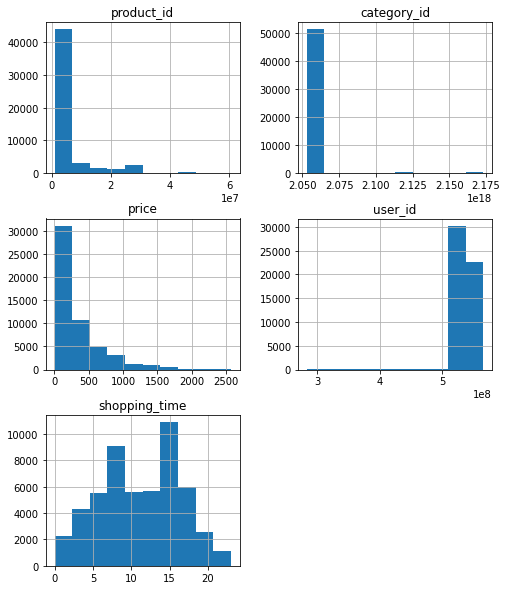

In [ ]:
rcParams['figure.figsize'] = 8,10
shopping_sample.hist()

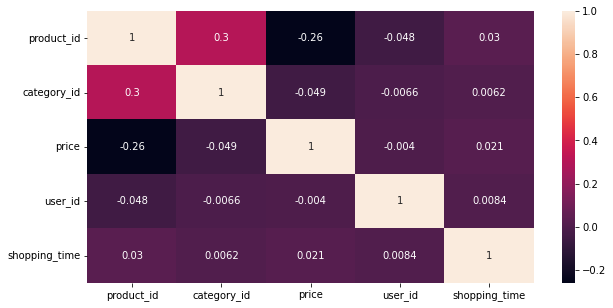

In [ ]:
# Creating a Correlation Matrix to understand the correlation between numeric columns
rcParams['figure.figsize'] = 10,5
sns.heatmap(shopping_sample.corr(), annot=True)
# There is some correlation between price and shopping_time

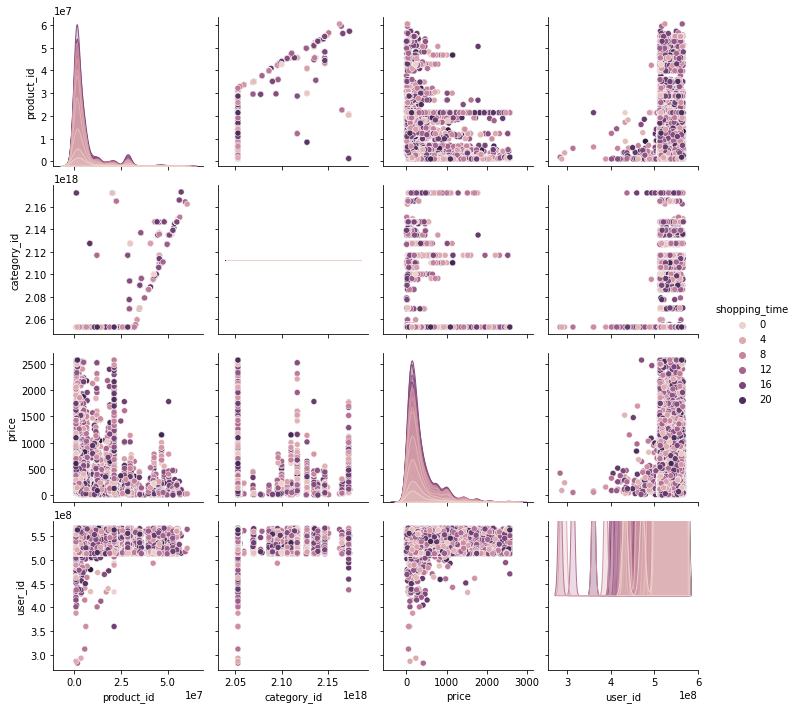

In [ ]:
sns.pairplot(data=shopping_sample, hue='shopping_time')

In [ ]:
# Dropping columns that are not needed for this analysis
shopping_sample.drop(['event_time', 'product_id', 'category_id', 'user_id', 'user_session'], axis=1, inplace=True)

In [ ]:
# Rearraging the columns for better readability
column_order = ['brand', 'category_code', 'product_code', 'price', 'event_type', 'shopping_time']
shopping_sample = shopping_sample.reindex(columns=column_order)

In [ ]:
#Creating a new column 'Coupon' to show whether the user used a coupon before or not. I am randomly synthesizing boolean values
shopping_sample['coupon'] = random.choices(['Yes', 'No'], weights=[6, 4], k=53121)

In [ ]:
shopping_sample['coupon'].value_counts()

Yes    32001
No     21120
Name: coupon, dtype: int64

In [ ]:
shopping_sample.head()

,brand,category_code,product_code,price,event_type,shopping_time,coupon
10799447,starline,auto,alarm,138.23,cart,10,Yes
33053086,samsung,electronics,smartphone,280.87,cart,16,No
20288110,samsung,electronics,smartphone,250.69,cart,18,No
5073499,polaris,appliances,iron,43.48,cart,3,Yes
21143662,samsung,electronics,smartphone,131.64,cart,11,Yes


In [ ]:
# Saving the cleaned up sample dataframe as a .csv file
shopping_sample.to_csv('/content/drive/MyDrive/Colab Notebooks/data/shopping_sample.csv')

#### Data Visualization

Text(0.5, 1.0, 'Shopping Category')

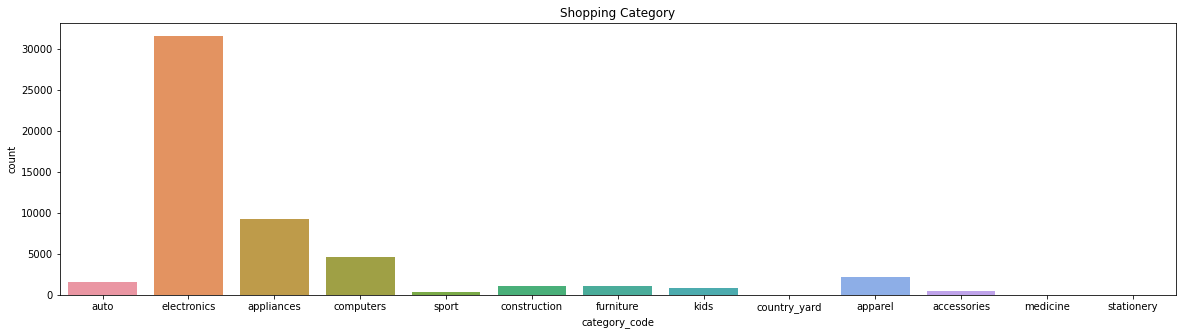

In [ ]:
# Shopping Category
rcParams['figure.figsize'] = 20,5
sns.countplot(data=shopping_sample, x='category_code')
plt.title('Shopping Category')
# For the selected sample, 'electronics' is the most common shopping category viewed, in cart or purchased

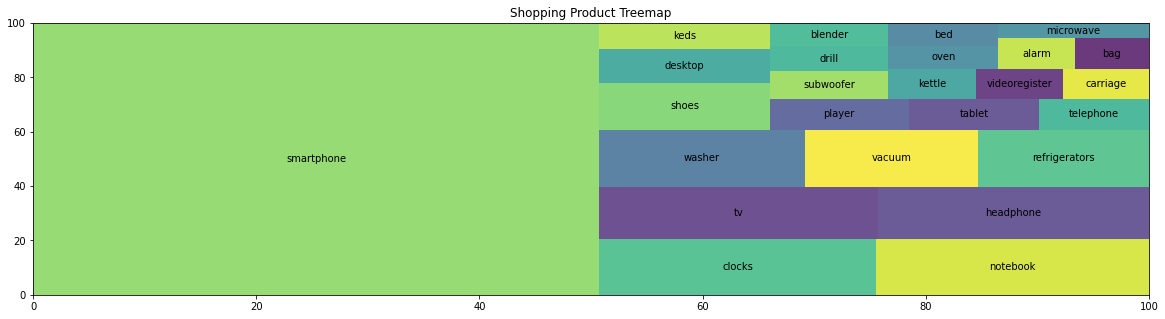

In [ ]:
# Shopping Product - Top 25
rcParams['figure.figsize'] = 20, 5
squarify.plot(sizes=shopping_sample['product_code'].value_counts().iloc[:25].tolist(), label=shopping_sample['product_code'].value_counts().iloc[:25].keys().tolist(), alpha=0.8)
plt.title('Shopping Product Treemap')
#plt.axis('off')
plt.show()
# For the selected sample, 'smartphone' is the most common shopping product viewed, in cart or purchased

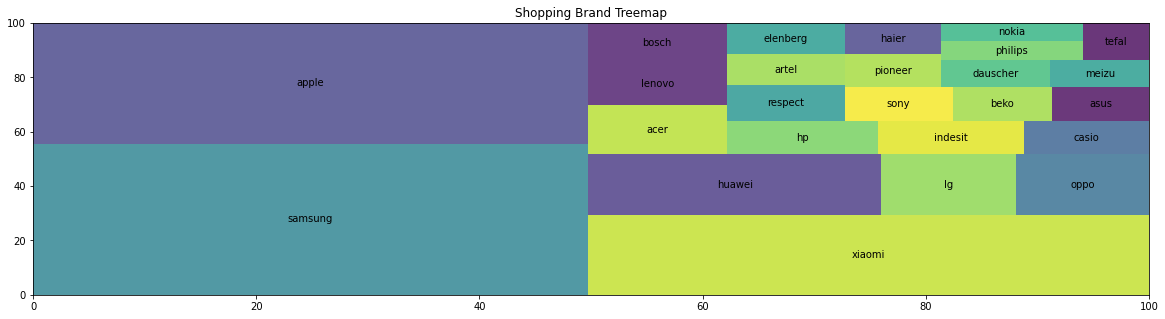

In [ ]:
# Shopping Brand - Top 25
rcParams['figure.figsize'] = 20, 5
squarify.plot(sizes=shopping_sample['brand'].value_counts().iloc[:25].tolist(), label=shopping_sample['brand'].value_counts().iloc[:25].keys().tolist(), alpha=0.8)
plt.title('Shopping Brand Treemap')
#plt.axis('off')
plt.show()
# For the selected sample, 'samsung' and 'apple' are the most common shopping brand viewed, in cart or purchased

Text(0.5, 1.0, 'Shopping Event Type')

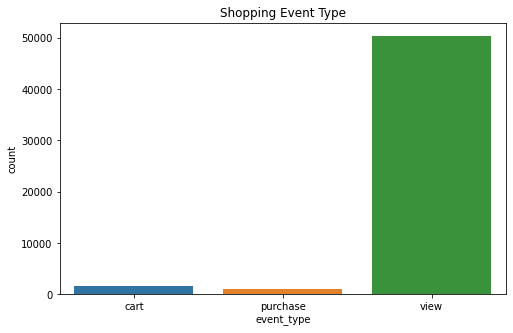

In [ ]:
# Event Type
rcParams['figure.figsize'] = 8, 5
sns.countplot(data=shopping_sample, x='event_type')
plt.title('Shopping Event Type')
# For the selected sample, approx. 95% of the shoppers were viewing products than it was put in cart or purchased

Text(0.5, 1.0, 'Shopping TIme and Event Type')

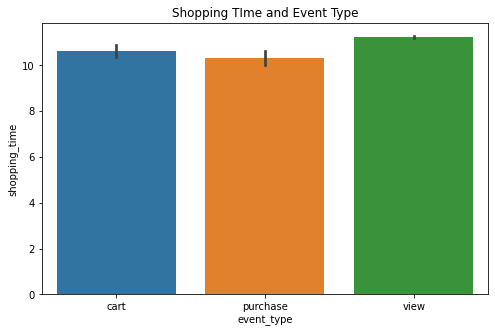

In [ ]:
# Shopping Time and Event Type
rcParams['figure.figsize'] = 8, 5
ax = sns.barplot(data=shopping_sample, x='event_type', y='shopping_time')
plt.title('Shopping TIme and Event Type')

Text(0.5, 1.0, 'Coupon Acceptance Rate')

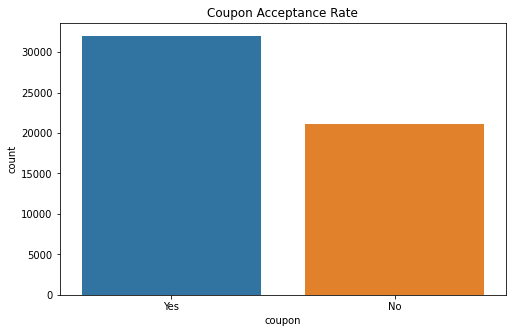

In [ ]:
# Coupon
rcParams['figure.figsize'] = 8, 5
sns.countplot(data=shopping_sample, x='coupon')
plt.title('Coupon Acceptance Rate')
# For the selected sample, more coupons were viewed or used by user than rejecting it

Text(0.5, 1.0, 'Shopping TIme and Coupon Acceptance')

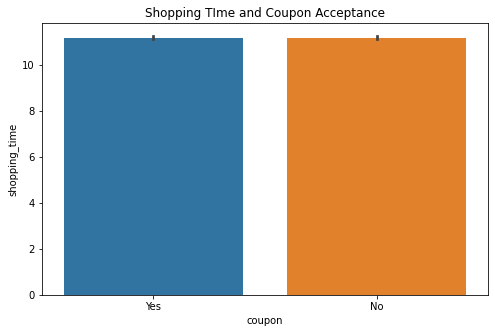

In [ ]:
# Shopping Time and Coupon
rcParams['figure.figsize'] = 8, 5
ax = sns.barplot(data=shopping_sample, x='coupon', y='shopping_time')
plt.title('Shopping TIme and Coupon Acceptance')
# Availability or acceptance of a coupon didnt influence much on the shopping time taken by the users

Text(0.5, 1.0, 'Event Type and Coupon Acceptance')

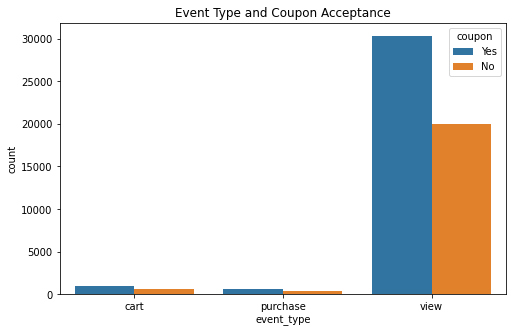

In [ ]:
# Event Type and Coupon
rcParams['figure.figsize'] = 8, 5
ax = sns.countplot(data=shopping_sample, x='event_type', hue='coupon')
plt.title('Event Type and Coupon Acceptance')
# Availability or acceptance of a coupon did influence the user event_type activity

Text(0.5, 1.0, 'Shopping TIme and Event Type with Coupon Acceptance')

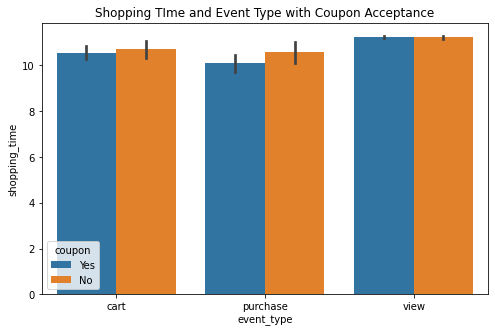

In [ ]:
# Shopping Time and Event Type with Coupon Acceptance
rcParams['figure.figsize'] = 8, 5
ax = sns.barplot(data=shopping_sample, x='event_type', y='shopping_time', hue='coupon')
plt.title('Shopping TIme and Event Type with Coupon Acceptance')

Text(0.5, 1.0, 'Shopping Category with Price and Event Type')

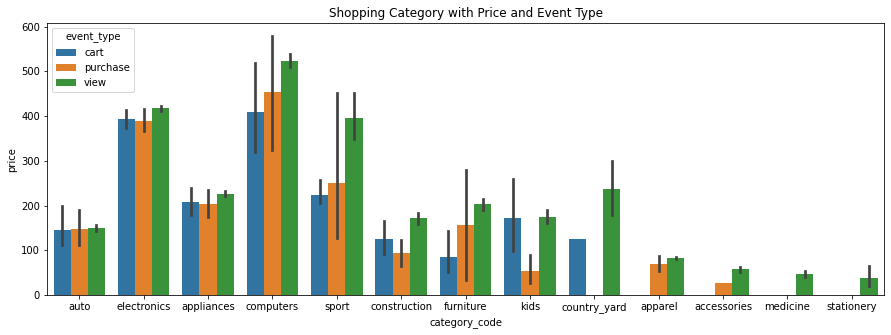

In [ ]:
# Shopping Category and Price
rcParams['figure.figsize'] = 15, 5
ax = sns.barplot(data=shopping_sample, x='category_code', y='price', hue='event_type')
plt.title('Shopping Category with Price and Event Type')
# For the selected sample, 'electronics' and 'computers' are the most purchased shopping categories. They are also on the top product in the view and in-cart event_type.

In [ ]:
top25_product_list = shopping_sample['product_code'].value_counts().iloc[:25].index

In [ ]:
top25_product_df = shopping_sample.loc[shopping_sample['product_code'].isin(top25_product_list)]

Text(0.5, 1.0, 'Top 25 Shopping Product with Price and Event Type')

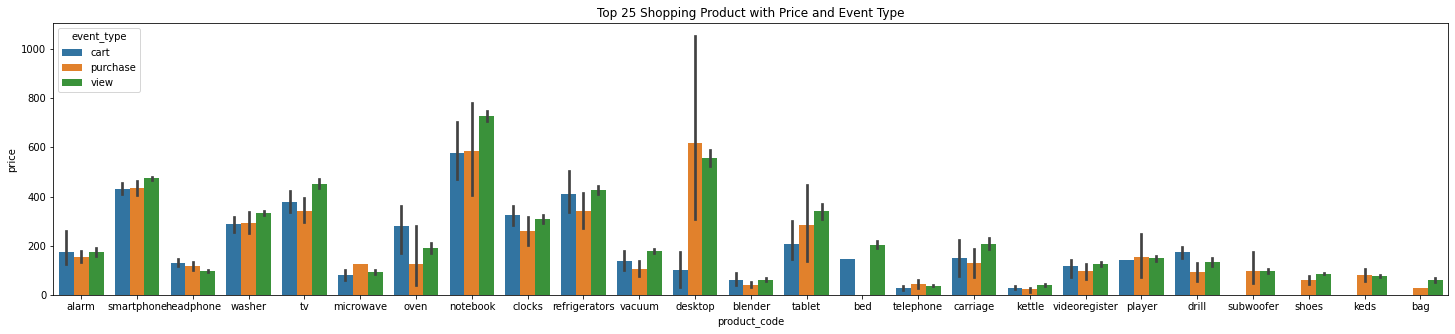

In [ ]:
# Top 25 Shopping Products and Price
rcParams['figure.figsize'] = 25, 5
ax = sns.barplot(data=top25_product_df, x='product_code', y='price', hue='event_type')
plt.title('Top 25 Shopping Product with Price and Event Type')
# For the selected sample, 'notebook', 'smartphone', 'tablet' and 'desktop' are the most purchased shopping products. They are also on the top shopping products in the view and in-cart event_type.

In [ ]:
top25_brand_list = shopping_sample['brand'].value_counts().iloc[:25].index

In [ ]:
top25_brand_df = shopping_sample.loc[shopping_sample['brand'].isin(top25_brand_list)]

Text(0.5, 1.0, 'Top 25 Shopping Brands with Price and Event Type')

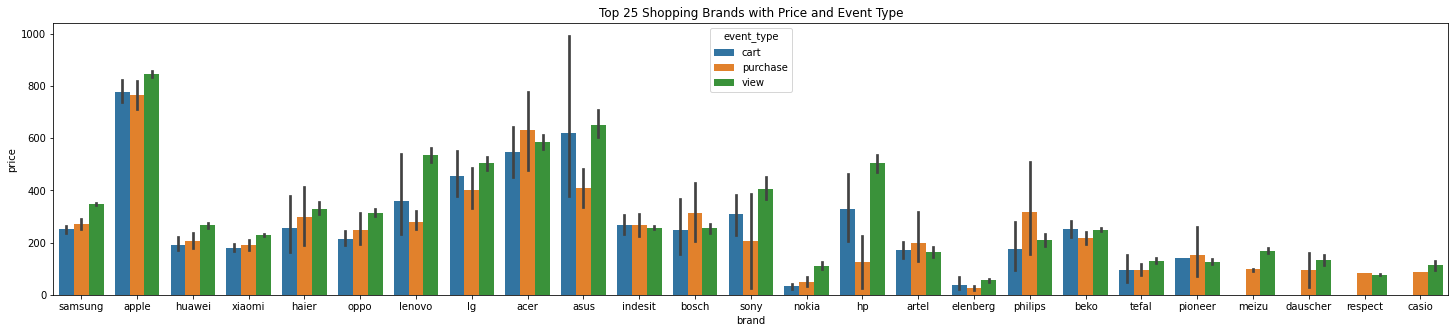

In [ ]:
# Top 25 Shopping Brands and Price
rcParams['figure.figsize'] = 25, 5
ax = sns.barplot(data=top25_brand_df, x='brand', y='price', hue='event_type')
plt.title('Top 25 Shopping Brands with Price and Event Type')
# For the selected sample, 'apple', 'asus', 'lenovo' and 'hp' are the most purchased shopping brands. They are also on the top shopping brands in the view and in-cart event_type.

Text(0.5, 1.0, 'Shopping Category with Shopping Time and Event Type')

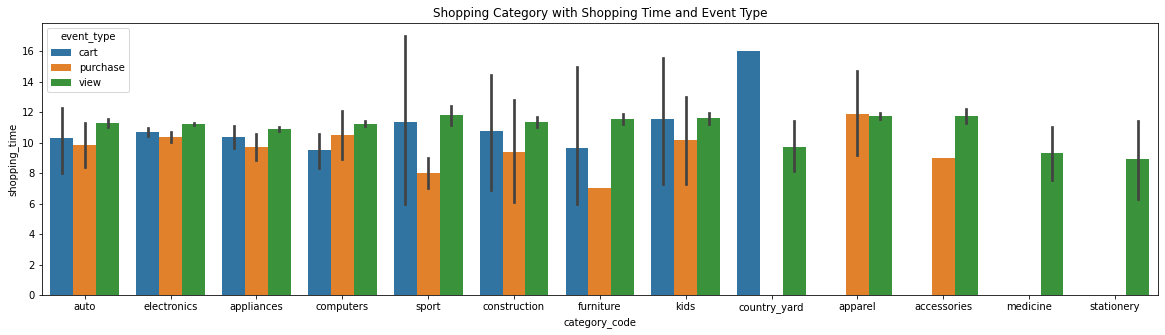

In [ ]:
# Shopping Category with Shopping Time and Event Type
rcParams['figure.figsize'] = 20, 5
ax = sns.barplot(data=shopping_sample, x='category_code', y='shopping_time', hue='event_type')
plt.title('Shopping Category with Shopping Time and Event Type')
# For the selected sample, 'accessories' and 'sport' shopping categories shows the higest shopping time but both of them ended up in purchases.

Text(0.5, 1.0, 'Top 25 Shopping Product with Shopping Time and Event Type')

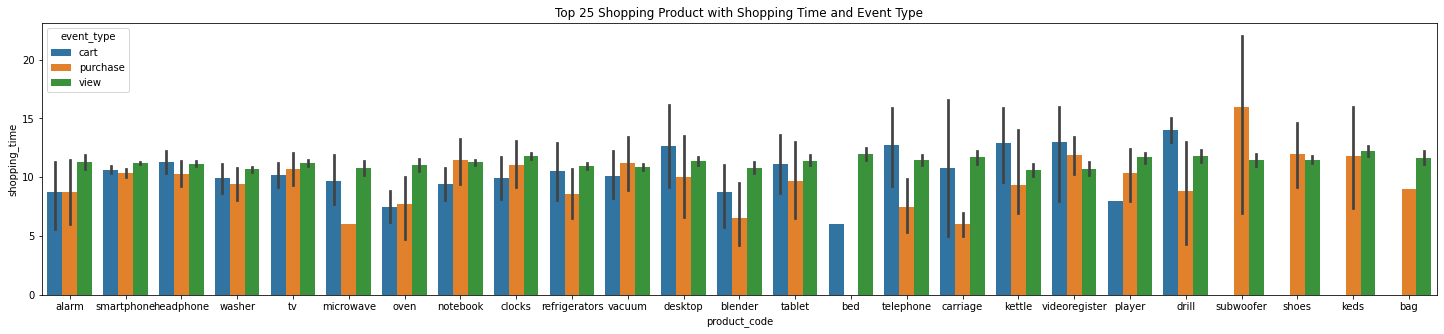

In [ ]:
# Shopping Product with Shopping Time and Event Type
rcParams['figure.figsize'] = 25, 5
ax = sns.barplot(data=top25_product_df, x='product_code', y='shopping_time', hue='event_type')
plt.title('Top 25 Shopping Product with Shopping Time and Event Type')
# For the selected sample, 'bag', 'desktop', and 'oven' shopping products shows the higest shopping time but all of them ended up in purchases.

Text(0.5, 1.0, 'Top 25 Shopping Brands with Shopping Time and Event Type')

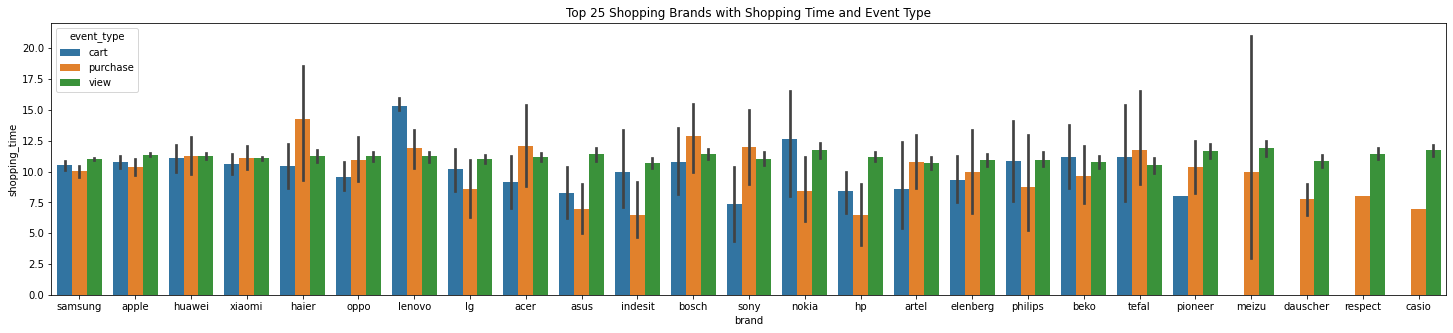

In [ ]:
# Top 25 Shopping Brands with Shopping Time and Event Type
rcParams['figure.figsize'] = 25, 5
ax = sns.barplot(data=top25_brand_df, x='brand', y='shopping_time', hue='event_type')
plt.title('Top 25 Shopping Brands with Shopping Time and Event Type')
# For the selected sample, 'sony', 'asus', and 'tefal' shopping brands shows the higest shopping time but all of them ended up in purchases.